"""

@Topic: Pricing of Accommodation Rental Under Log Linear Market Value Model

@Usage: 
        1. Process the Airbnb listings;
        2. Obtain the ideal weight vector through linear regression;
        3. Save feature vectors.
        
@Author: Chaoyue Niu

@Email: rvince@sjtu.edu.cn

"""

# Load Libraries

In [168]:
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
import seaborn as sns
import statsmodels.api as sm
import statsmodels as statm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
#from plotnine import *

# Load File

In [169]:
filedata= pd.read_csv('./input/us/train.csv')

# Exploratory Data Analysis(EDA)

## File structure and content

In [170]:
filedata.head(5)

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,...,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
0,6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,...,40.696524,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0
1,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,...,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0
2,7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,...,40.808110,-73.943756,The Garden Oasis,Harlem,10,92.0,https://a0.muscache.com/im/pictures/6fae5362-9...,10027,1.0,3.0
3,13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,True,...,37.772004,-122.431619,Beautiful Flat in the Heart of SF!,Lower Haight,0,NaN,https://a0.muscache.com/im/pictures/72208dad-9...,94117.0,2.0,2.0
4,3808709,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,True,...,38.925627,-77.034596,Great studio in midtown DC,Columbia Heights,4,40.0,NaN,20009,0.0,1.0


In [171]:
len(filedata.columns)

29

In [172]:
filedata.shape

(74111, 29)

In [173]:
filedata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74111 entries, 0 to 74110
Data columns (total 29 columns):
id                        74111 non-null int64
log_price                 74111 non-null float64
property_type             74111 non-null object
room_type                 74111 non-null object
amenities                 74111 non-null object
accommodates              74111 non-null int64
bathrooms                 73911 non-null float64
bed_type                  74111 non-null object
cancellation_policy       74111 non-null object
cleaning_fee              74111 non-null bool
city                      74111 non-null object
description               74111 non-null object
first_review              58247 non-null object
host_has_profile_pic      73923 non-null object
host_identity_verified    73923 non-null object
host_response_rate        55812 non-null object
host_since                73923 non-null object
instant_bookable          74111 non-null object
last_review               582

In [174]:
#check for missing data, and output columns that have missing data
for col in filedata:
    if (filedata[col].isnull().any()):
        print(col)

bathrooms
first_review
host_has_profile_pic
host_identity_verified
host_response_rate
host_since
last_review
neighbourhood
review_scores_rating
thumbnail_url
zipcode
bedrooms
beds


In [175]:
#fills missing data with 0s
#GO BACK TO THIS, 0 may not be best fill for all missing data
filedata=filedata.fillna(0)

In [176]:
#summary stats on each of the numeric columns
filedata.describe()

,id,log_price,accommodates,bathrooms,latitude,longitude,number_of_reviews,review_scores_rating,bedrooms,beds
count,7.411100e+04,74111.000000,74111.000000,74111.000000,74111.000000,74111.000000,74111.000000,74111.000000,74111.000000,74111.000000
mean,1.126662e+07,4.782069,3.155146,1.231929,38.445958,-92.397525,20.900568,72.842520,1.264239,1.707844
std,6.081735e+06,0.717394,2.153589,0.584780,3.080167,21.705322,37.828641,39.920507,0.852773,1.255092
min,3.440000e+02,0.000000,1.000000,0.000000,33.338905,-122.511500,0.000000,0.000000,0.000000,0.000000
25%,6.261964e+06,4.317488,2.000000,1.000000,34.127908,-118.342374,1.000000,80.000000,1.000000,1.000000
50%,1.225415e+07,4.709530,2.000000,1.000000,40.662138,-76.996965,6.000000,94.000000,1.000000,1.000000
75%,1.640226e+07,5.220356,4.000000,1.000000,40.746096,-73.954660,23.000000,99.000000,1.000000,2.000000
max,2.123090e+07,7.600402,16.000000,8.000000,42.390437,-70.985047,605.000000,100.000000,10.000000,18.000000


In [177]:
#check all the statistics
filedata.describe(include='all')

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,...,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
count,7.411100e+04,74111.000000,74111,74111,74111,74111.000000,74111.000000,74111,74111,74111,...,74111.000000,74111.000000,74111,74111.0,74111.000000,74111.000000,74111.0,74111,74111.000000,74111.000000
unique,NaN,NaN,35,3,67122,NaN,NaN,5,5,2,...,NaN,NaN,73359,620.0,NaN,NaN,65884.0,770,NaN,NaN
top,NaN,NaN,Apartment,Entire home/apt,{},NaN,NaN,Real Bed,strict,True,...,NaN,NaN,Bunk bed in the Treat Street Clubhouse,0.0,NaN,NaN,0.0,11211.0,NaN,NaN
freq,NaN,NaN,49003,41310,586,NaN,NaN,72028,32374,54403,...,NaN,NaN,8,6872.0,NaN,NaN,8216.0,1368,NaN,NaN
mean,1.126662e+07,4.782069,NaN,NaN,NaN,3.155146,1.231929,NaN,NaN,NaN,...,38.445958,-92.397525,NaN,NaN,20.900568,72.842520,NaN,NaN,1.264239,1.707844
std,6.081735e+06,0.717394,NaN,NaN,NaN,2.153589,0.584780,NaN,NaN,NaN,...,3.080167,21.705322,NaN,NaN,37.828641,39.920507,NaN,NaN,0.852773,1.255092
min,3.440000e+02,0.000000,NaN,NaN,NaN,1.000000,0.000000,NaN,NaN,NaN,...,33.338905,-122.511500,NaN,NaN,0.000000,0.000000,NaN,NaN,0.000000,0.000000
25%,6.261964e+06,4.317488,NaN,NaN,NaN,2.000000,1.000000,NaN,NaN,NaN,...,34.127908,-118.342374,NaN,NaN,1.000000,80.000000,NaN,NaN,1.000000,1.000000
50%,1.225415e+07,4.709530,NaN,NaN,NaN,2.000000,1.000000,NaN,NaN,NaN,...,40.662138,-76.996965,NaN,NaN,6.000000,94.000000,NaN,NaN,1.000000,1.000000
75%,1.640226e+07,5.220356,NaN,NaN,NaN,4.000000,1.000000,NaN,NaN,NaN,...,40.746096,-73.954660,NaN,NaN,23.000000,99.000000,NaN,NaN,1.000000,2.000000


/usr/local/anaconda3/envs/py2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


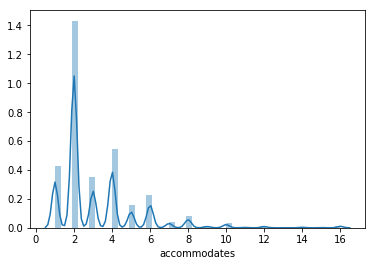

In [178]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64','uint8']
numericdataX = filedata.select_dtypes(include=numerics)
x= numericdataX['accommodates']
sns.distplot(x);

/usr/local/anaconda3/envs/py2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


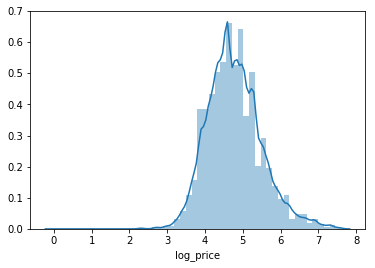

In [179]:
x= numericdataX.iloc[:,1]
sns.distplot(x);

In [180]:
#check categorical data
filedata.describe(include=['O'])

,property_type,room_type,amenities,bed_type,cancellation_policy,city,description,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,name,neighbourhood,thumbnail_url,zipcode
count,74111,74111,74111,74111,74111,74111,74111,74111,74111,74111,74111,74111,74111,74111,74111,74111,74111,74111
unique,35,3,67122,5,5,6,73479,2555,3,3,81,3088,2,1372,73359,620,65884,770
top,Apartment,Entire home/apt,{},Real Bed,strict,NYC,"Hello, I've been running guest house for Korea...",0,t,t,100%,2015-03-30,f,0,Bunk bed in the Treat Street Clubhouse,0,0,11211.0
freq,49003,41310,586,72028,32374,32349,8,15864,73697,49748,43254,246,54660,15827,8,6872,8216,1368


In [181]:
#check numeric data
filedata.describe()

,id,log_price,accommodates,bathrooms,latitude,longitude,number_of_reviews,review_scores_rating,bedrooms,beds
count,7.411100e+04,74111.000000,74111.000000,74111.000000,74111.000000,74111.000000,74111.000000,74111.000000,74111.000000,74111.000000
mean,1.126662e+07,4.782069,3.155146,1.231929,38.445958,-92.397525,20.900568,72.842520,1.264239,1.707844
std,6.081735e+06,0.717394,2.153589,0.584780,3.080167,21.705322,37.828641,39.920507,0.852773,1.255092
min,3.440000e+02,0.000000,1.000000,0.000000,33.338905,-122.511500,0.000000,0.000000,0.000000,0.000000
25%,6.261964e+06,4.317488,2.000000,1.000000,34.127908,-118.342374,1.000000,80.000000,1.000000,1.000000
50%,1.225415e+07,4.709530,2.000000,1.000000,40.662138,-76.996965,6.000000,94.000000,1.000000,1.000000
75%,1.640226e+07,5.220356,4.000000,1.000000,40.746096,-73.954660,23.000000,99.000000,1.000000,2.000000
max,2.123090e+07,7.600402,16.000000,8.000000,42.390437,-70.985047,605.000000,100.000000,10.000000,18.000000


In [182]:
filedata.columns

Index([u'id', u'log_price', u'property_type', u'room_type', u'amenities',
       u'accommodates', u'bathrooms', u'bed_type', u'cancellation_policy',
       u'cleaning_fee', u'city', u'description', u'first_review',
       u'host_has_profile_pic', u'host_identity_verified',
       u'host_response_rate', u'host_since', u'instant_bookable',
       u'last_review', u'latitude', u'longitude', u'name', u'neighbourhood',
       u'number_of_reviews', u'review_scores_rating', u'thumbnail_url',
       u'zipcode', u'bedrooms', u'beds'],
      dtype='object')

# Linear Assumptions

## Assumption that data point are linearly disributed 

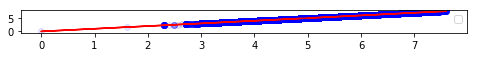

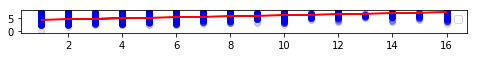

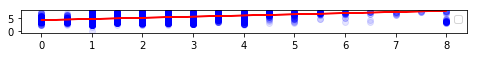

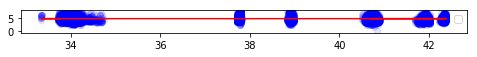

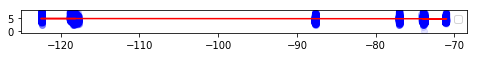

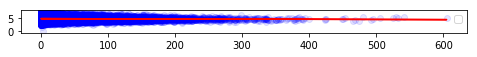

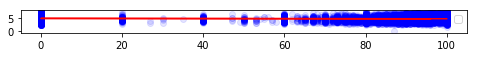

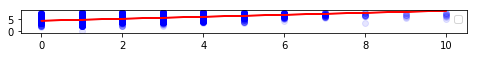

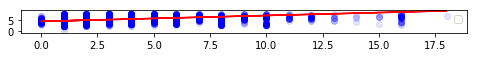

In [183]:
regressor = linear_model.LinearRegression()
for i in range(1,10): 
    x= np.array(numericdataX.iloc[:,i]).reshape(-1,1)
    y= np.array(filedata['log_price']).reshape(-1,1)
    regressor.fit(x,y)
    plt.figure(figsize=(8,5))
    plt.subplot(10,1,i)
    plt.scatter(x,y,color='blue', alpha=0.1)
    plt.plot(x,regressor.predict(x),color="red")
    plt.legend()

## Q-Q plot


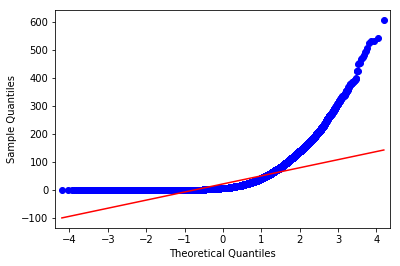

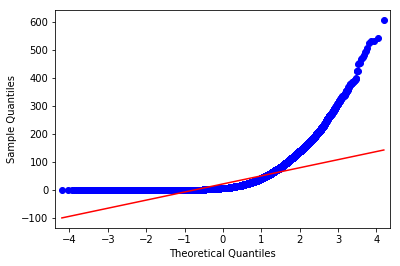

In [184]:
statm.graphics.gofplots.qqplot(numericdataX.iloc[:,6], line='r')

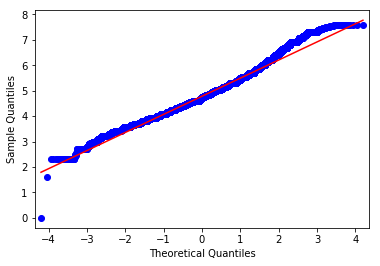

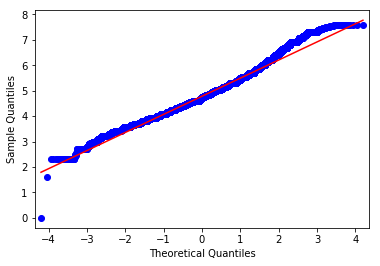

In [185]:
statm.graphics.gofplots.qqplot(numericdataX.iloc[:,1], line='r')

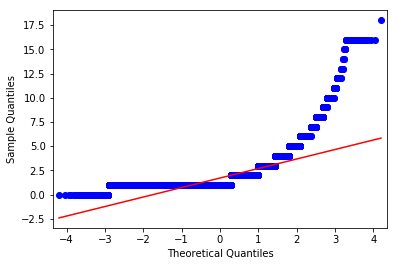

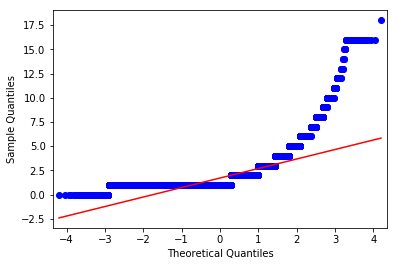

In [186]:
statm.graphics.gofplots.qqplot(numericdataX.iloc[:,9], line='r')

# Linear Regression

### Functions

In [187]:
def checkCorrelation(data):
    """
    Plot correlation Matrix for given data
   :param data: dataset having features
   :return: return plot representing pearson correlation
   """
    plt.figure(figsize=(20, 20))
    sns.heatmap(data.corr(),linewidths=0.25,vmax=1.0,square=True,cmap="BuGn_r", 
    linecolor='w',annot=True)

In [188]:
#return Model 
def data_model(xdata):
    """
     fits linear regression model on given data
    :param xdata: independent variable dataset
    :return: linear regression model with fit of xdata 
    """
    #add constant to data
    X = sm.add_constant(xdata)
    targetY=filedata[['log_price']]
    y = targetY

    # Fit the linear model
    model = linear_model.LinearRegression()
    results = model.fit(X, y)
    model = sm.OLS(y, X)
    results = model.fit()
    return results

In [189]:
#save Model 
def save_model(xdata):
    """
    fits linear regression model on given data
    :param xdata: independent variable dataset
    :return: linear regression model with fit of xdata 
    """
    #add constant to data
    X = sm.add_constant(xdata)
    y = X[['log_price']]
    #y=filedata[['log_price']]
    X = X.drop(['log_price'],axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1)

    # Fit the linear model
    lr = linear_model.LinearRegression()
    lr.fit(X_train, y_train)
    y_train_pred = lr.predict(X_train)
    y_test_pred = lr.predict(X_test)
    print('MSE train: %.3f, test: %.3f' % (
           mean_squared_error(y_train, y_train_pred),
           mean_squared_error(y_test, y_test_pred)))
    print('R^2 train: %.3f, test: %.3f' % (
           r2_score(y_train, y_train_pred),
           r2_score(y_test, y_test_pred)))
    
    #save paramters
    regrCoef = lr.coef_.transpose()
    regrb = lr.intercept_
    print((np.linalg.norm(regrCoef,2))**2.0)
    np.savetxt("./new-input/us_full_X", X, fmt='%.10f')
    np.savetxt("./new-input/us_full_y", y, fmt='%.10f')
    np.savetxt("./new-input/us_train_X", X_train, fmt='%.10f')
    np.savetxt("./new-input/us_train_y", y_train, fmt='%.10f')
    np.savetxt("./new-input/us_test_X", X_test, fmt='%.10f')
    np.savetxt("./new-input/us_test_y", y_test, fmt='%.10f')
    np.savetxt("./new-input/us_w", regrCoef, fmt='%.10f')
    np.savetxt("./new-input/us_b", regrb, fmt='%.10f')

In [190]:
def data_summary(xdata):
    """
    Returns chart having summary of data
   :param xdata: independent variable dataset
   :return: summary of data 
   """
    results = data_model(xdata)
    return results.summary()

In [191]:
def crossValidationError(data):
    """
   Finds cross validation error of model
   :param X: independent variable dataset
   :return: float value returns mean squared error
   """
    numericdataX=data
    X = np.array(numericdataX.drop(['log_price'],axis=1), dtype=pd.Series)
    Y = np.array(numericdataX['log_price'], dtype=pd.Series)
    regr1 = linear_model.LinearRegression()
    ms_errors= cross_val_score(regr1, X, Y, cv=5, scoring = make_scorer(mean_squared_error))
    rms_errors = np.sqrt(ms_errors)
    mean_rms_error = rms_errors.mean()
    return mean_rms_error

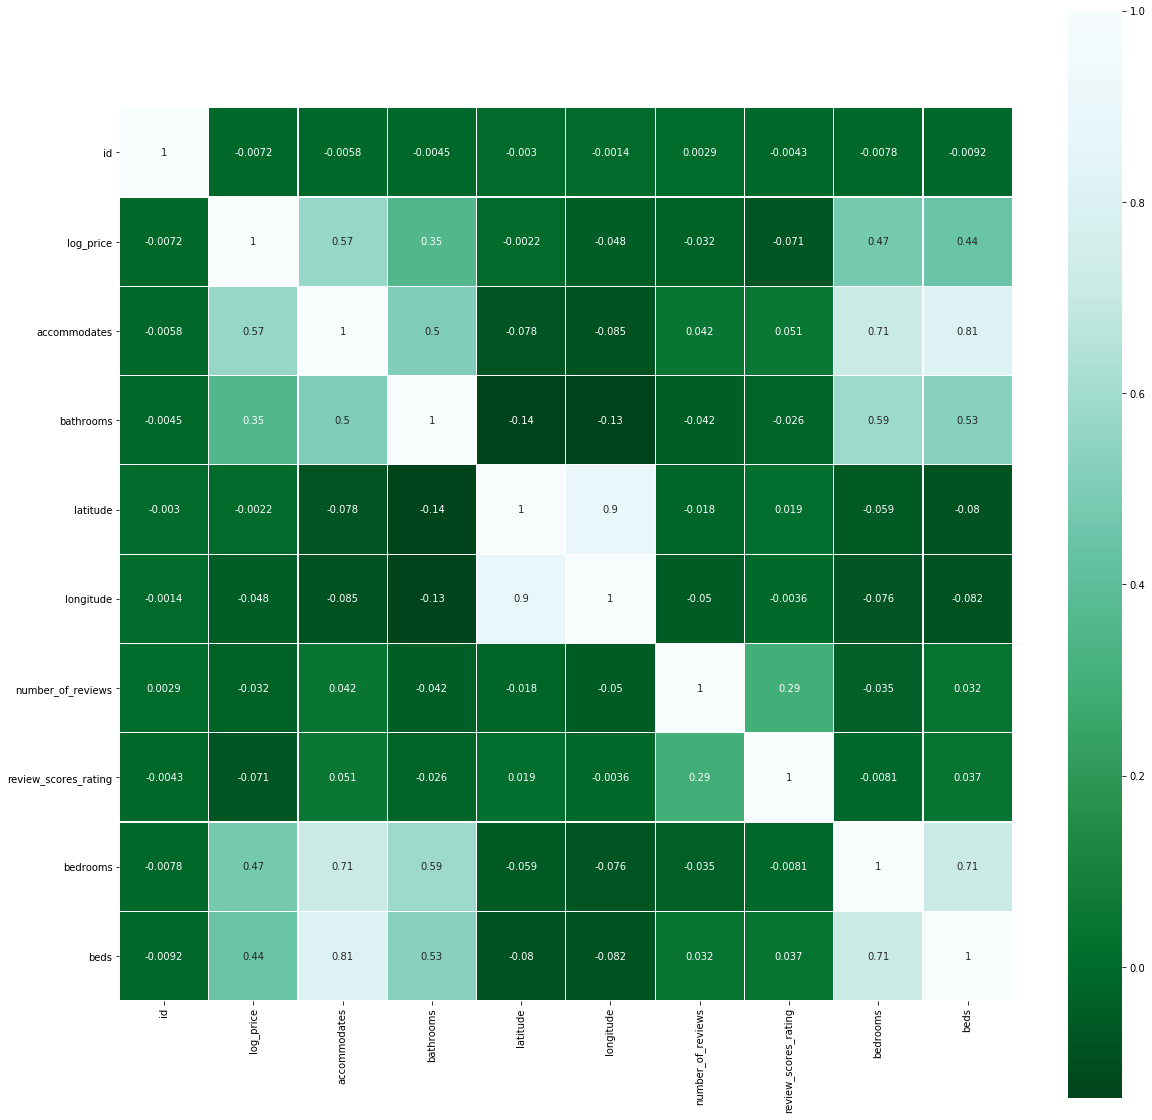

In [192]:
#Checking correlation in data
checkCorrelation(numericdataX)

In [193]:
#So as per correlation matrix colums such as latitude, longitude, number_of_reviews and review_scores_rating are not making much impact on log_price
#as valueof cirrelation is poor
#lets drop them from our dataset
numericdataX=numericdataX.drop(['id','number_of_reviews',
       'review_scores_rating','latitude',
       'longitude' ], axis=1)

In [194]:
# buid model and check summary
data_summary(numericdataX.drop(['log_price'],axis=1))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.339
Model:                            OLS   Adj. R-squared:                  0.339
Method:                 Least Squares   F-statistic:                     9510.
Date:                Fri, 22 Feb 2019   Prob (F-statistic):               0.00
Time:                        21:11:24   Log-Likelihood:                -65191.
No. Observations:               74111   AIC:                         1.304e+05
Df Residuals:                   74106   BIC:                         1.304e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            4.0903      0.005    802.368      0.000       4.080       4.100
accommodates     0.1789      0.002     99.635      0.000       0.175       0.182
bathrooms        0.0816      0.005     17.684      0.000       0.073       0.091
bedrooms         0.1226      0.004     30.756      0.000       0.115       0.130
beds            -0.0751      0.003    -24.223      0.000      -0.081      -0.069
==============================================================================
Omnibus:                     3121.068   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7042.969
Skew:                           0.268   Prob(JB):                         0.00
Kurtosis:                       4.412   Cond. No.                         13.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [195]:
# there is also correlation between bathroom and accomodates and bedroom lets only keep acomodates
numericdataX = numericdataX.drop(['bathrooms','bedrooms','beds'], axis=1)

In [196]:
# buid model and check summary
data_summary(numericdataX.drop(['log_price'],axis=1))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.322
Model:                            OLS   Adj. R-squared:                  0.322
Method:                 Least Squares   F-statistic:                 3.522e+04
Date:                Fri, 22 Feb 2019   Prob (F-statistic):               0.00
Time:                        21:11:24   Log-Likelihood:                -66136.
No. Observations:               74111   AIC:                         1.323e+05
Df Residuals:                   74109   BIC:                         1.323e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            4.1855      0.004   1087.557      0.000       4.178       4.193
accommodates     0.1891      0.001    187.667      0.000       0.187       0.191
==============================================================================
Omnibus:                     3644.340   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9778.639
Skew:                           0.258   Prob(JB):                         0.00
Kurtosis:                       4.703   Cond. No.                         7.10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [197]:
crossValidationError(numericdataX)

0.5906434455693734

## Handling Categorical Variables

In [198]:
filedata.room_type.value_counts()

Entire home/apt    41310
Private room       30638
Shared room         2163
Name: room_type, dtype: int64

In [199]:
#creating dummy variable for column room_type
numericdataX=pd.concat([numericdataX,filedata['room_type']], axis=1)
numericdataX=pd.get_dummies(numericdataX,columns= ['room_type'],drop_first=True)

In [200]:
numericdataX

,log_price,accommodates,room_type_Private room,room_type_Shared room
0,5.010635,3,0,0
1,5.129899,7,0,0
2,4.976734,5,0,0
3,6.620073,4,0,0
4,4.744932,2,0,0
5,4.442651,2,1,0
6,4.418841,3,0,0
7,4.787492,2,0,0
8,4.787492,2,1,0
9,3.583519,2,1,0


In [201]:
filedata.bed_type.value_counts()

Real Bed         72028
Futon              753
Pull-out Sofa      585
Airbed             477
Couch              268
Name: bed_type, dtype: int64

In [202]:
numericdataX=pd.concat([numericdataX,filedata['bed_type']], axis=1)
numericdataX=pd.get_dummies(numericdataX,columns=['bed_type'],drop_first=True)

In [203]:
filedata.cancellation_policy.value_counts()

strict             32374
flexible           22545
moderate           19063
super_strict_30      112
super_strict_60       17
Name: cancellation_policy, dtype: int64

In [204]:
numericdataX=pd.concat([numericdataX,filedata['cancellation_policy']], axis=1)
numericdataX=pd.get_dummies(numericdataX,columns=['cancellation_policy'],drop_first=True)

In [205]:
filedata.city.value_counts()

NYC        32349
LA         22453
SF          6434
DC          5688
Chicago     3719
Boston      3468
Name: city, dtype: int64

In [206]:
numericdataX=pd.concat([numericdataX,filedata['city']], axis=1)
numericdataX=pd.get_dummies(numericdataX,columns=['city'],drop_first=True)

In [207]:
filedata.instant_bookable.value_counts()
numericdataX=pd.concat([numericdataX,filedata['instant_bookable']], axis=1)
numericdataX=pd.get_dummies(numericdataX,columns=['instant_bookable'],drop_first=True)

# Multicolinearity

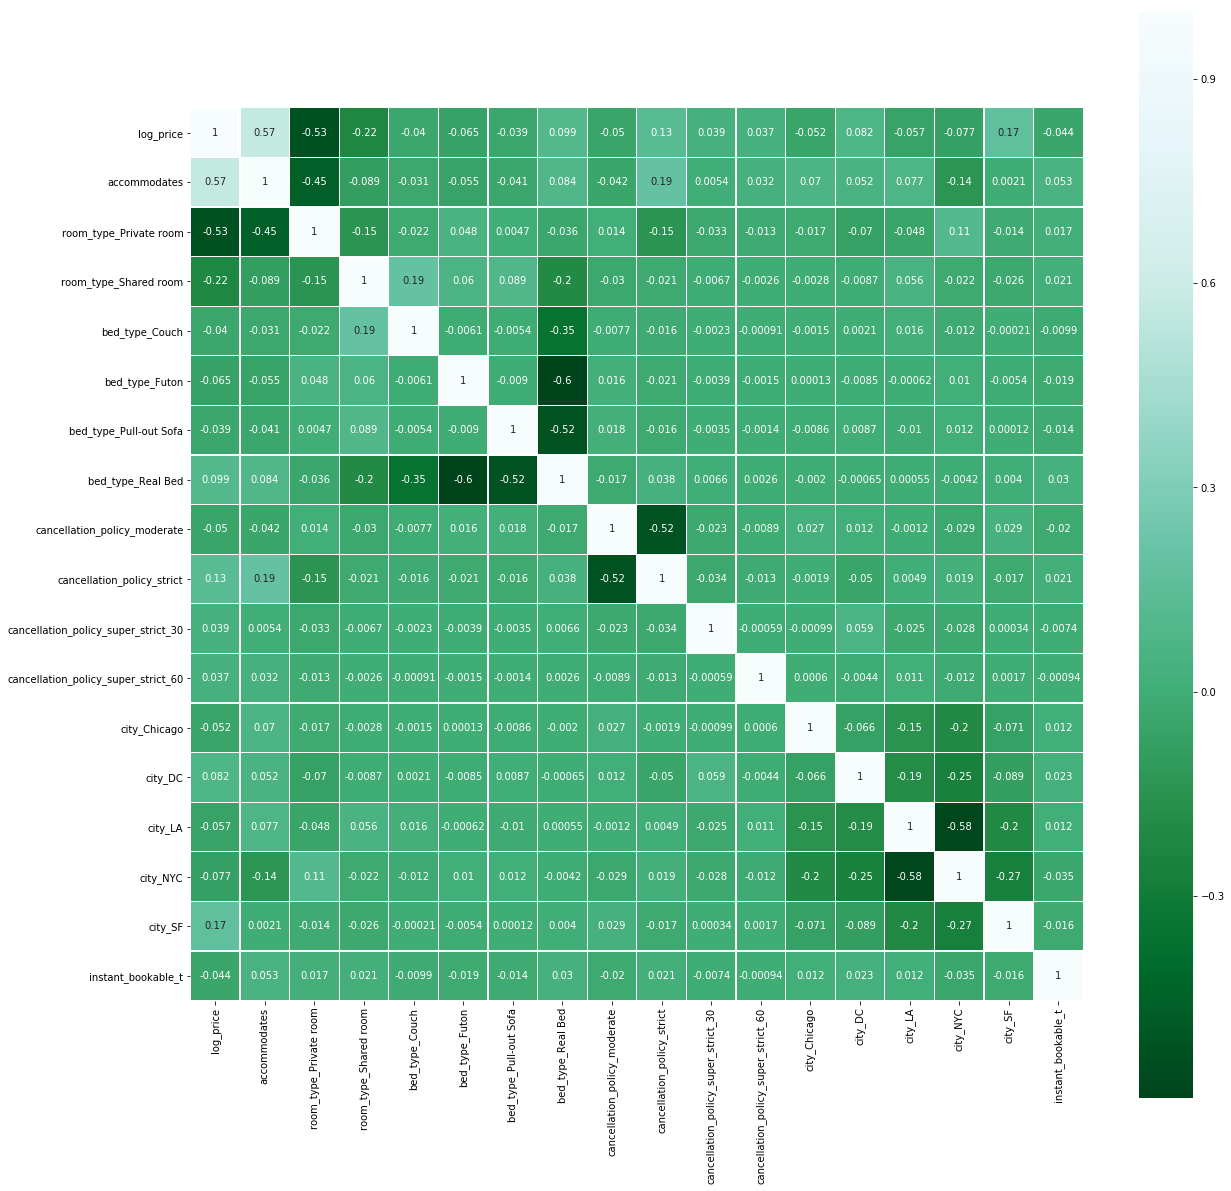

In [208]:
checkCorrelation(numericdataX)

In [209]:
data_summary(numericdataX.drop(['log_price'],axis=1))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.516
Model:                            OLS   Adj. R-squared:                  0.516
Method:                 Least Squares   F-statistic:                     4652.
Date:                Fri, 22 Feb 2019   Prob (F-statistic):               0.00
Time:                        21:11:27   Log-Likelihood:                -53631.
No. Observations:               74111   AIC:                         1.073e+05
Df Residuals:                   74093   BIC:                         1.075e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                   4.7122      0.025    189.245      0.000       4.663       4.761
accommodates                            0.1268      0.001    127.763      0.000       0.125       0.129
room_type_Private room                 -0.5762      0.004   -133.420      0.000      -0.585      -0.568
room_type_Shared room                  -1.0229      0.012    -88.508      0.000      -1.046      -1.000
bed_type_Couch                          0.1592      0.038      4.156      0.000       0.084       0.234
bed_type_Futon                         -0.0229      0.029     -0.783      0.433      -0.080       0.034
bed_type_Pull-out Sofa                  0.0263      0.031      0.853      0.394      -0.034       0.087
bed_type_Real Bed                       0.0479      0.023      2.079      0.038       0.003       0.093
cancellation_policy_moderate           -0.0893      0.005    -18.061      0.000      -0.099      -0.080
cancellation_policy_strict             -0.0451      0.004    -10.128      0.000      -0.054      -0.036
cancellation_policy_super_strict_30     0.2908      0.047      6.128      0.000       0.198       0.384
cancellation_policy_super_strict_60     0.8926      0.121      7.367      0.000       0.655       1.130
city_Chicago                           -0.3080      0.012    -26.082      0.000      -0.331      -0.285
city_DC                                 0.0340      0.011      3.158      0.002       0.013       0.055
city_LA                                -0.1448      0.009    -15.855      0.000      -0.163      -0.127
city_NYC                               -0.0374      0.009     -4.179      0.000      -0.055      -0.020
city_SF                                 0.3136      0.011     29.769      0.000       0.293       0.334
instant_bookable_t                     -0.0819      0.004    -19.548      0.000      -0.090      -0.074
==============================================================================
Omnibus:                     9176.469   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            25616.477
Skew:                           0.682   Prob(JB):                         0.00
Kurtosis:                       5.537   Cond. No.                         269.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [210]:
filedata.property_type.value_counts()
numericdataX=pd.concat([numericdataX,filedata['property_type']], axis=1)
numericdataX=pd.get_dummies(numericdataX,columns=['property_type'],drop_first=True)

In [211]:
data_summary(numericdataX.drop(['log_price'],axis=1))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.523
Model:                            OLS   Adj. R-squared:                  0.523
Method:                 Least Squares   F-statistic:                     1592.
Date:                Fri, 22 Feb 2019   Prob (F-statistic):               0.00
Time:                        21:11:27   Log-Likelihood:                -53117.
No. Observations:               74111   AIC:                         1.063e+05
Df Residuals:                   74059   BIC:                         1.068e+05
Df Model:                          51                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                   4.6954      0.025    189.295      0.000       4.647       4.744
accommodates                            0.1242      0.001    121.801      0.000       0.122       0.126
room_type_Private room                 -0.5865      0.004   -131.048      0.000      -0.595      -0.578
room_type_Shared room                  -0.9999      0.012    -85.383      0.000      -1.023      -0.977
bed_type_Couch                          0.1366      0.038      3.585      0.000       0.062       0.211
bed_type_Futon                         -0.0246      0.029     -0.847      0.397      -0.082       0.032
bed_type_Pull-out Sofa                  0.0257      0.031      0.841      0.400      -0.034       0.086
bed_type_Real Bed                       0.0501      0.023      2.185      0.029       0.005       0.095
cancellation_policy_moderate           -0.0879      0.005    -17.892      0.000      -0.098      -0.078
cancellation_policy_strict             -0.0456      0.004    -10.302      0.000      -0.054      -0.037
cancellation_policy_super_strict_30     0.3037      0.047      6.442      0.000       0.211       0.396
cancellation_policy_super_strict_60     0.7988      0.121      6.610      0.000       0.562       1.036
city_Chicago                           -0.3098      0.012    -26.395      0.000      -0.333      -0.287
city_DC                                 0.0356      0.011      3.309      0.001       0.015       0.057
city_LA                                -0.1388      0.009    -15.085      0.000      -0.157      -0.121
city_NYC                               -0.0218      0.009     -2.438      0.015      -0.039      -0.004
city_SF                                 0.3140      0.011     29.893      0.000       0.293       0.335
instant_bookable_t                     -0.0812      0.004    -19.498      0.000      -0.089      -0.073
property_type_Bed & Breakfast           0.1709      0.023      7.331      0.000       0.125       0.217
property_type_Boat                      0.2634      0.062      4.278      0.000       0.143       0.384
property_type_Boutique hotel            0.3358      0.060      5.613      0.000       0.219       0.453
property_type_Bungalow                 -0.0501      0.026     -1.910      0.056      -0.101       0.001
property_type_Cabin                    -0.1021      0.059     -1.744      0.081      -0.217       0.013
property_type_Camper/RV                -0.2224      0.051     -4.337      0.000      -0.323      -0.122
property_type_Casa particular           0.3187      0.496      0.643      0.520      -0.653       1.290
property_type_Castle                    0.3732      0.138      2.714      0.007       0.104       0.643
property_type_Cave                      0.2710      0.351      0.77

In [212]:
crossValidationError(numericdataX)

0.49598872488071805

In [213]:
# P value of bed type has poor P value
numericdataX = numericdataX.loc[:, ~numericdataX.columns.str.startswith('bed_type_')]

In [214]:
data_summary(numericdataX.drop(['log_price'],axis=1))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.523
Model:                            OLS   Adj. R-squared:                  0.522
Method:                 Least Squares   F-statistic:                     1726.
Date:                Fri, 22 Feb 2019   Prob (F-statistic):               0.00
Time:                        21:11:29   Log-Likelihood:                -53133.
No. Observations:               74111   AIC:                         1.064e+05
Df Residuals:                   74063   BIC:                         1.068e+05
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                   4.7445      0.010    475.621      0.000       4.725       4.764
accommodates                            0.1243      0.001    121.946      0.000       0.122       0.126
room_type_Private room                 -0.5875      0.004   -131.442      0.000      -0.596      -0.579
room_type_Shared room                  -1.0003      0.011    -87.976      0.000      -1.023      -0.978
cancellation_policy_moderate           -0.0884      0.005    -17.987      0.000      -0.098      -0.079
cancellation_policy_strict             -0.0457      0.004    -10.315      0.000      -0.054      -0.037
cancellation_policy_super_strict_30     0.3041      0.047      6.451      0.000       0.212       0.397
cancellation_policy_super_strict_60     0.7985      0.121      6.606      0.000       0.562       1.035
city_Chicago                           -0.3099      0.012    -26.399      0.000      -0.333      -0.287
city_DC                                 0.0358      0.011      3.328      0.001       0.015       0.057
city_LA                                -0.1384      0.009    -15.045      0.000      -0.156      -0.120
city_NYC                               -0.0217      0.009     -2.420      0.016      -0.039      -0.004
city_SF                                 0.3144      0.011     29.921      0.000       0.294       0.335
instant_bookable_t                     -0.0808      0.004    -19.411      0.000      -0.089      -0.073
property_type_Bed & Breakfast           0.1714      0.023      7.348      0.000       0.126       0.217
property_type_Boat                      0.2641      0.062      4.289      0.000       0.143       0.385
property_type_Boutique hotel            0.3368      0.060      5.628      0.000       0.219       0.454
property_type_Bungalow                 -0.0513      0.026     -1.957      0.050      -0.103    7.56e-05
property_type_Cabin                    -0.1069      0.059     -1.826      0.068      -0.222       0.008
property_type_Camper/RV                -0.2250      0.051     -4.387      0.000      -0.325      -0.124
property_type_Casa particular           0.3199      0.496      0.645      0.519      -0.652       1.292
property_type_Castle                    0.3739      0.138      2.718      0.007       0.104       0.644
property_type_Cave                      0.2725      0.351      0.777      0.437      -0.415       0.960
property_type_Chalet                    0.0727      0.202      0.359      0.719      -0.324       0.469
property_type_Condominium               0.1784      0.010     17.749      0.000       0.159       0.198
property_type_Dorm                     -0.4610      0.042    -10.951      0.000      -0.543      -0.378
property_type_Earth House               0.3026      0.248      1.22

In [215]:
crossValidationError(numericdataX)

0.4960731325731074

# Interaction Term

In [216]:
filedata.columns

Index([u'id', u'log_price', u'property_type', u'room_type', u'amenities',
       u'accommodates', u'bathrooms', u'bed_type', u'cancellation_policy',
       u'cleaning_fee', u'city', u'description', u'first_review',
       u'host_has_profile_pic', u'host_identity_verified',
       u'host_response_rate', u'host_since', u'instant_bookable',
       u'last_review', u'latitude', u'longitude', u'name', u'neighbourhood',
       u'number_of_reviews', u'review_scores_rating', u'thumbnail_url',
       u'zipcode', u'bedrooms', u'beds'],
      dtype='object')

In [217]:
interactionDF= pd.DataFrame()
interactionDF['bedrooms']=filedata['bedrooms']
interactionDF['beds']=filedata['beds']
interactionDF['bathrooms']=filedata['bathrooms']
interactionDF['bed*bathroom*bedrooms']=filedata['bedrooms']*filedata['beds']*filedata['bathrooms']
data_summary(interactionDF)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.253
Model:                            OLS   Adj. R-squared:                  0.253
Method:                 Least Squares   F-statistic:                     6273.
Date:                Fri, 22 Feb 2019   Prob (F-statistic):               0.00
Time:                        21:11:31   Log-Likelihood:                -69737.
No. Observations:               74111   AIC:                         1.395e+05
Df Residuals:                   74106   BIC:                         1.395e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     4.1058      0.007    631.154      0.000       4.093       4.119
bedrooms                  0.2497      0.004     60.615      0.000       0.242       0.258
beds                      0.1252      0.003     45.403      0.000       0.120       0.131
bathrooms                 0.1287      0.005     24.845      0.000       0.119       0.139
bed*bathroom*bedrooms    -0.0022      0.000    -15.032      0.000      -0.002      -0.002
==============================================================================
Omnibus:                     2340.676   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5478.523
Skew:                           0.162   Prob(JB):                         0.00
Kurtosis:                       4.292   Cond. No.                         77.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [218]:
numericdataX= pd.concat([numericdataX,interactionDF],axis=1)
data_summary(numericdataX.drop(['log_price'],axis=1))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.554
Model:                            OLS   Adj. R-squared:                  0.554
Method:                 Least Squares   F-statistic:                     1805.
Date:                Fri, 22 Feb 2019   Prob (F-statistic):               0.00
Time:                        21:11:32   Log-Likelihood:                -50609.
No. Observations:               74111   AIC:                         1.013e+05
Df Residuals:                   74059   BIC:                         1.018e+05
Df Model:                          51                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                   4.5779      0.010    438.087      0.000       4.557       4.598
accommodates                            0.0815      0.002     50.153      0.000       0.078       0.085
room_type_Private room                 -0.6190      0.004   -142.170      0.000      -0.628      -0.611
room_type_Shared room                  -1.0384      0.011    -93.729      0.000      -1.060      -1.017
cancellation_policy_moderate           -0.0721      0.005    -15.156      0.000      -0.081      -0.063
cancellation_policy_strict             -0.0371      0.004     -8.655      0.000      -0.045      -0.029
cancellation_policy_super_strict_30     0.2683      0.046      5.888      0.000       0.179       0.358
cancellation_policy_super_strict_60     0.6201      0.117      5.307      0.000       0.391       0.849
city_Chicago                           -0.3031      0.011    -26.714      0.000      -0.325      -0.281
city_DC                                 0.0496      0.010      4.763      0.000       0.029       0.070
city_LA                                -0.1292      0.009    -14.507      0.000      -0.147      -0.112
city_NYC                               -0.0099      0.009     -1.145      0.252      -0.027       0.007
city_SF                                 0.3107      0.010     30.589      0.000       0.291       0.331
instant_bookable_t                     -0.0611      0.004    -15.125      0.000      -0.069      -0.053
property_type_Bed & Breakfast           0.1548      0.023      6.863      0.000       0.111       0.199
property_type_Boat                      0.2890      0.060      4.854      0.000       0.172       0.406
property_type_Boutique hotel            0.4042      0.058      6.986      0.000       0.291       0.518
property_type_Bungalow                 -0.0175      0.025     -0.692      0.489      -0.067       0.032
property_type_Cabin                    -0.0815      0.057     -1.439      0.150      -0.192       0.029
property_type_Camper/RV                -0.1208      0.050     -2.435      0.015      -0.218      -0.024
property_type_Casa particular           0.4163      0.479      0.869      0.385      -0.523       1.356
property_type_Castle                    0.3780      0.133      2.843      0.004       0.117       0.639
property_type_Cave                      0.3317      0.339      0.979      0.328      -0.332       0.996
property_type_Chalet                    0.0552      0.196      0.282      0.778      -0.328       0.439
property_type_Condominium               0.1419      0.010     14.581      0.000       0.123       0.161
property_type_Dorm                     -0.5040      0.041    -12.294      0.000      -0.584      -0.424
property_type_Earth House               0.4579      0.240      1.91

In [219]:
interactionDF1= pd.DataFrame()
interactionDF1['review_scores_rating']=filedata['review_scores_rating']
interactionDF1['number_of_reviews']=filedata['number_of_reviews']
interactionDF1['reiew_score*Number']=filedata['review_scores_rating']*filedata['number_of_reviews']
data_summary(interactionDF1)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     203.4
Date:                Fri, 22 Feb 2019   Prob (F-statistic):          2.11e-131
Time:                        21:11:32   Log-Likelihood:                -80240.
No. Observations:               74111   AIC:                         1.605e+05
Df Residuals:                   74107   BIC:                         1.605e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    4.8812      0.005    890.988      0.000       4.870       4.892
review_scores_rating    -0.0013    6.9e-05    -18.608      0.000      -0.001      -0.001
number_of_reviews       -0.0198      0.001    -15.218      0.000      -0.022      -0.017
reiew_score*Number       0.0002   1.38e-05     15.055      0.000       0.000       0.000
==============================================================================
Omnibus:                     3064.221   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3695.192
Skew:                           0.468   Prob(JB):                         0.00
Kurtosis:                       3.567   Cond. No.                     8.52e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.52e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [220]:
numericdataX= pd.concat([numericdataX,interactionDF1],axis=1)
numericdataX

,log_price,accommodates,room_type_Private room,room_type_Shared room,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60,city_Chicago,city_DC,...,property_type_Vacation home,property_type_Villa,property_type_Yurt,bedrooms,beds,bathrooms,bed*bathroom*bedrooms,review_scores_rating,number_of_reviews,reiew_score*Number
0,5.010635,3,0,0,0,1,0,0,0,0,...,0,0,0,1.0,1.0,1.0,1.0,100.0,2,200.0
1,5.129899,7,0,0,0,1,0,0,0,0,...,0,0,0,3.0,3.0,1.0,9.0,93.0,6,558.0
2,4.976734,5,0,0,1,0,0,0,0,0,...,0,0,0,1.0,3.0,1.0,3.0,92.0,10,920.0
3,6.620073,4,0,0,0,0,0,0,0,0,...,0,0,0,2.0,2.0,1.0,4.0,0.0,0,0.0
4,4.744932,2,0,0,1,0,0,0,0,1,...,0,0,0,0.0,1.0,1.0,0.0,40.0,4,160.0
5,4.442651,2,1,0,0,1,0,0,0,0,...,0,0,0,1.0,1.0,1.0,1.0,100.0,3,300.0
6,4.418841,3,0,0,1,0,0,0,0,0,...,0,0,0,1.0,1.0,1.0,1.0,97.0,15,1455.0
7,4.787492,2,0,0,1,0,0,0,0,0,...,0,0,0,1.0,1.0,1.0,1.0,93.0,9,837.0
8,4.787492,2,1,0,1,0,0,0,0,0,...,0,0,0,1.0,1.0,1.0,1.0,99.0,159,15741.0
9,3.583519,2,1,0,1,0,0,0,0,0,...,0,0,0,1.0,1.0,1.0,1.0,90.0,2,180.0


In [221]:
data_summary(numericdataX.drop(['log_price'],axis=1))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.568
Model:                            OLS   Adj. R-squared:                  0.568
Method:                 Least Squares   F-statistic:                     1802.
Date:                Fri, 22 Feb 2019   Prob (F-statistic):               0.00
Time:                        21:11:32   Log-Likelihood:                -49455.
No. Observations:               74111   AIC:                         9.902e+04
Df Residuals:                   74056   BIC:                         9.953e+04
Df Model:                          54                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                   4.6964      0.011    440.497      0.000       4.675       4.717
accommodates                            0.0841      0.002     52.503      0.000       0.081       0.087
room_type_Private room                 -0.6197      0.004   -144.409      0.000      -0.628      -0.611
room_type_Shared room                  -1.0514      0.011    -96.298      0.000      -1.073      -1.030
cancellation_policy_moderate           -0.0180      0.005     -3.686      0.000      -0.028      -0.008
cancellation_policy_strict              0.0207      0.004      4.666      0.000       0.012       0.029
cancellation_policy_super_strict_30     0.3042      0.045      6.779      0.000       0.216       0.392
cancellation_policy_super_strict_60     0.6266      0.115      5.446      0.000       0.401       0.852
city_Chicago                           -0.2963      0.011    -26.507      0.000      -0.318      -0.274
city_DC                                 0.0334      0.010      3.257      0.001       0.013       0.054
city_LA                                -0.1393      0.009    -15.878      0.000      -0.156      -0.122
city_NYC                               -0.0131      0.009     -1.538      0.124      -0.030       0.004
city_SF                                 0.3027      0.010     30.252      0.000       0.283       0.322
instant_bookable_t                     -0.0518      0.004    -12.977      0.000      -0.060      -0.044
property_type_Bed & Breakfast           0.1687      0.022      7.595      0.000       0.125       0.212
property_type_Boat                      0.2715      0.059      4.631      0.000       0.157       0.386
property_type_Boutique hotel            0.4053      0.057      7.116      0.000       0.294       0.517
property_type_Bungalow                 -0.0136      0.025     -0.543      0.587      -0.062       0.035
property_type_Cabin                    -0.0808      0.056     -1.448      0.148      -0.190       0.029
property_type_Camper/RV                -0.1415      0.049     -2.898      0.004      -0.237      -0.046
property_type_Casa particular           0.2993      0.472      0.634      0.526      -0.626       1.224
property_type_Castle                    0.4109      0.131      3.139      0.002       0.154       0.668
property_type_Cave                      0.3501      0.334      1.049      0.294      -0.304       1.004
property_type_Chalet                    0.0315      0.193      0.163      0.870      -0.346       0.409
property_type_Condominium               0.1327      0.010     13.844      0.000       0.114       0.152
property_type_Dorm                     -0.4769      0.040    -11.812      0.000      -0.556      -0.398
property_type_Earth House               0.4447      0.236      1.88

In [222]:
save_model(numericdataX)

MSE train: 0.222, test: 0.226
R^2 train: 0.568, test: 0.566
5.796590964792256
